### Nikolaos Giannopoulos AM 5199
### Team: Trump Tariffed My Datasets

In [2]:
import pickle
import ast
import numpy as np
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity


with open('Data/authors_preprocessing.pkl', 'rb') as f:
    raw_author_dict = pickle.load(f)

#Now extract the values (each is a string representing a list of authors)
raw_author_lists = list(raw_author_dict.values())

In [3]:
author_lists = []

for entry in raw_author_lists:
    try:
        authors = ast.literal_eval(entry) if isinstance(entry, str) else entry
        if isinstance(authors, list) and len(authors) > 1:
            authors = [a.strip().lower() for a in authors]
            author_lists.append(authors)
    except Exception as e:
        print(f"Skipping bad entry: {entry} ({e})")

In [4]:
coauthor_pairs = set()

for authors in author_lists:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            pair = tuple(sorted((authors[i], authors[j])))
            coauthor_pairs.add(pair)

In [5]:
G = nx.Graph()
G.add_edges_from(coauthor_pairs)

print(f"Graph built! {G.number_of_nodes()} authors, {G.number_of_edges()} co-authorships.")

Graph built! 144312 authors, 525273 co-authorships.


In [6]:
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
print("Sample nodes:", list(G.nodes())[:5])

Nodes: 144312, Edges: 525273
Sample nodes: ['guoshun huang', 'lin xiao', 'xiaoming deng', 'ye yuan', 'michael moeller']


In [7]:
#Original graph with string nodes
G_original = G

#Map string names to integer indices
name_to_id = {name: idx for idx, name in enumerate(G_original.nodes())}
id_to_name = {idx: name for name, idx in name_to_id.items()}

#Create a new graph with integer nodes
G_int = nx.Graph()
G_int.add_edges_from([(name_to_id[u], name_to_id[v]) for u, v in G_original.edges()])

print(f"Reindexed graph: {len(G_int.nodes())} nodes, {len(G_int.edges())} edges")

Reindexed graph: 144312 nodes, 525273 edges


In [9]:


#Use  original graph with string author names
node2vec = Node2Vec(G_original, dimensions=64, walk_length=15, num_walks=10, workers=3)

#Model fit
model = node2vec.fit(window=5, min_count=1, batch_words=4)


#Get embedding matrix for all nodes
embedding_dict = {node: model.wv[node] for node in G_original.nodes()}
model.wv.save_word2vec_format("author_embeddings_N2V.txt", binary=False)

Computing transition probabilities:   0%|          | 0/144312 [00:00<?, ?it/s]

In [15]:


#Create a new KeyedVectors object
cleaned_kv = KeyedVectors(vector_size=model.wv.vector_size)

#Replace spaces in keys before saving
for name in model.wv.index_to_key:
    cleaned_kv.add_vector(name.replace(" ", "_"), model.wv[name])

#Save in plain-text word2vec format
cleaned_kv.save_word2vec_format("author_embeddings_cleaned.txt", binary=False)

C:\Users\nicks\PycharmProjects\LinkPrediction\.venv\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [18]:
def link_score(author1, author2):
    if author1 in model.wv and author2 in model.wv:
        return cosine_similarity([model.wv[author1]], [model.wv[author2]])[0][0]
    else:
        return 0

# Try it on a known positive and a random negative
print("Real coauthors:", link_score('matthew fisher', 'shuran song'))
print("Random authors:", link_score('matthew fisher', 'barack obama'))  # unlikely

Real coauthors: 0.8280346
Random authors: 0


In [19]:
def top_similar_authors(author, top_n=10):
    if author not in model.wv:
        return []
    return model.wv.most_similar(author, topn=top_n)

print(top_similar_authors('matthew fisher'))

[('aleksey golovinskiy', 0.8939196467399597), ('vladimir kim', 0.8920906186103821), ('andy zeng', 0.8645110726356506), ('vladimir g kim', 0.8635072708129883), ('thomas funkhouser', 0.8624918460845947), ('samaneh azadi', 0.855980634689331), ('samuel p lichtenberg', 0.8528890013694763), ('sanjeev muralikrishnan', 0.8359927535057068), ('shuran song', 0.8280345797538757), ('francisco massa', 0.8114827275276184)]


In [21]:
model = KeyedVectors.load_word2vec_format("author_embeddings_cleaned.txt", binary=False)

In [26]:

#Pick a subset of authors to visualize (e.g. 200)
sample_authors = list(model.index_to_key)[:200]
vectors = np.array([model[author] for author in sample_authors])

#Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vectors_2d = tsne.fit_transform(vectors)

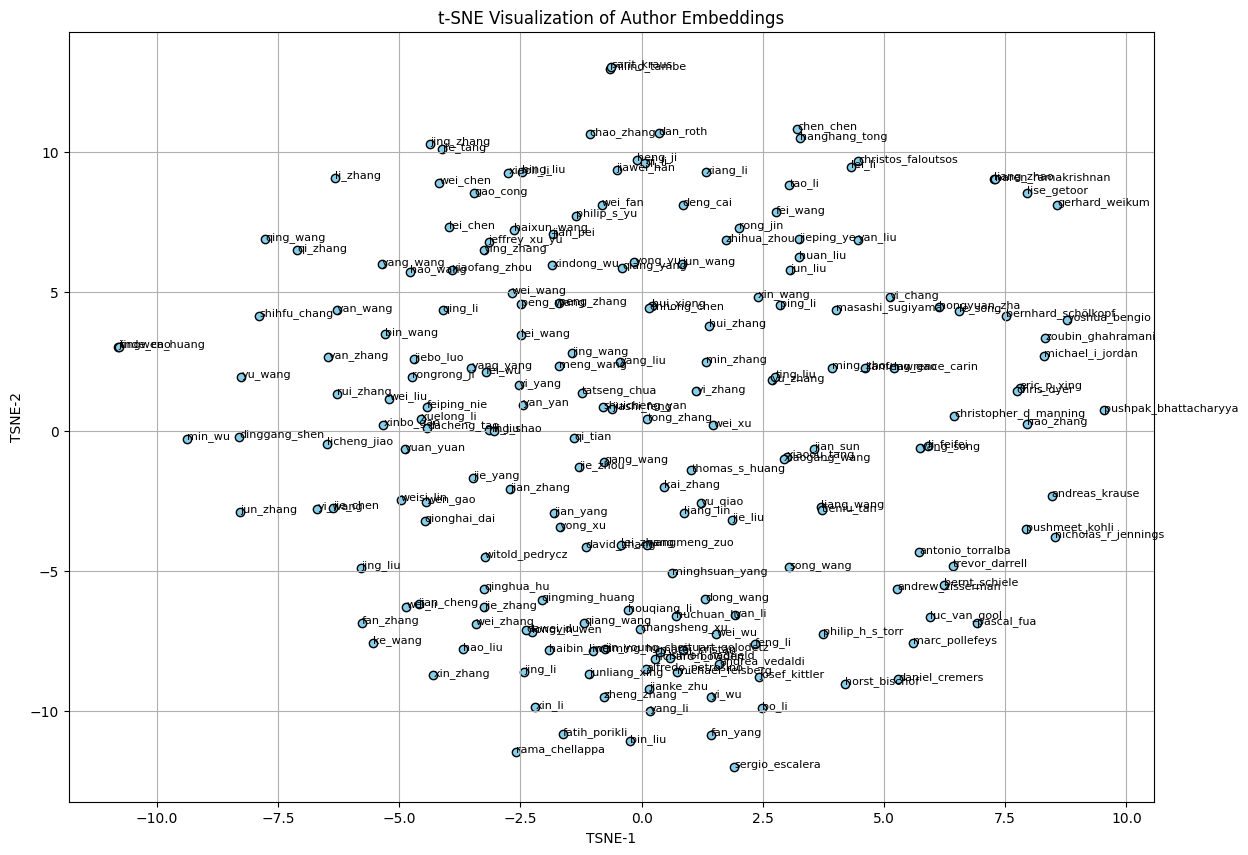

In [27]:
plt.figure(figsize=(14, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='skyblue')

# Annotate each point with the author name
for i, author in enumerate(sample_authors):
    plt.text(vectors_2d[i, 0], vectors_2d[i, 1], author, fontsize=8)

plt.title("t-SNE Visualization of Author Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()